In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
main_path = "/kaggle/input/kermany2018/OCT2017 "

# val, test, train have already been split in the kaggle database

train_dir = f"{main_path}/train"
val_dir = f"{main_path}/val"
test_dir = f"{main_path}/test"


In [4]:
# paths
print(train_dir)
print(val_dir)
print(test_dir)

/kaggle/input/kermany2018/OCT2017 /train
/kaggle/input/kermany2018/OCT2017 /val
/kaggle/input/kermany2018/OCT2017 /test


In [5]:
# diseases
os.listdir(train_dir)

['DRUSEN', 'CNV', 'NORMAL', 'DME']

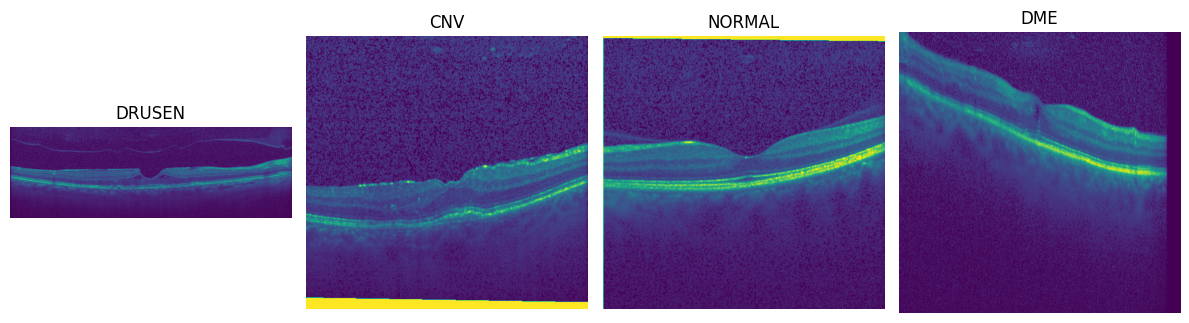

In [6]:
diseases = os.listdir(train_dir)

# Create a 2x2 subplot
fig, axs = plt.subplots(1, 4, figsize=(12, 5))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Ensure we don't try to plot more images than available axes
for i, ax in enumerate(axs):
    if i < len(diseases):
        disease = diseases[i]
        disease_dir = os.path.join(train_dir, disease)
        
        # List all images in the disease directory
        images = os.listdir(disease_dir)
        
        # Select a random image
        img_path = os.path.join(disease_dir, np.random.choice(images))
        
        # Load and display the image
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(disease)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

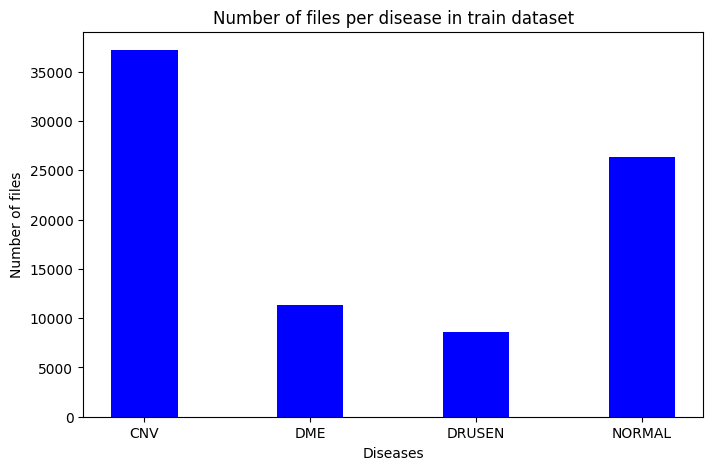

In [8]:
dataset = train_dir
image_counts = {"CNV": 0, "DME": 0, "DRUSEN": 0, "NORMAL": 0}

for disease in image_counts.keys(): 
    disease_dir = os.path.join(dataset, disease)
    image_counts[disease] = len(os.listdir(disease_dir))
    
diseases = list(image_counts.keys())
count = list(image_counts.values())

fig = plt.figure(figsize=(8,5))

plt.bar(diseases, count, color="blue", width = 0.4)

plt.xlabel("Diseases")
plt.ylabel("Number of files")
plt.title("Number of files per disease in train dataset")
plt.show()

# Training model using InceptionV3 pretrained model

In [9]:
batch_size = 32

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D,Input,concatenate, Lambda

In [11]:
image_gen = ImageDataGenerator(rescale=1/255, 
                              shear_range=0.15,
                              zoom_range=0.2, 
                              horizontal_flip=True,
                               rotation_range=25,
                              )

In [17]:
train_image_gen = image_gen.flow_from_directory(train_dir, 
                                                target_size=(299, 299),
                                                batch_size=32,
                                                color_mode="grayscale",
                                                shuffle=True
                                               )

Found 83484 images belonging to 4 classes.


In [18]:
test_image_gen = image_gen.flow_from_directory(test_dir, 
                                                target_size=(299, 299),
                                                batch_size=32,
                                                color_mode="grayscale",
                                                shuffle=True
                                               ) 

Found 968 images belonging to 4 classes.


In [30]:
input_shape = (299, 299, 1)

inputs = Input(shape=input_shape)

# three channels
x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])

inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=x)

x = Flatten()(inception_model.output)

# Fully connected layers
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)


# output
outputs = Dense(4, activation='softmax')(x)



final_model = tf.keras.Model(inputs=inputs, outputs=outputs)

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 299, 299,  │          0 │ input_layer_6[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_6[0]… │
│                     │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_564 (Conv2D) │ (None, 149, 149,  │        864 │ concatenate_18[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_564[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_564      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_565 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_564[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_565[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_565      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_566 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_565[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_566[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_566      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 73, 73,    │          0 │ activation_566[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_567 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_24… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_567[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_567      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_568 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_567[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 89,063,268 (339.75 MB)

 Trainable params: 89,027,300 (339.61 MB)

 Non-trainable params: 35,968 (140.50 KB)

In [25]:
# defining callback functions
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    patience=4,
    verbose=0,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint('InceptionV3_tuning.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')

In [ ]:
model_results = final_model.fit(train_image_gen,epochs=10,
                    validation_data=test_image_gen,
                    callbacks=[tensorboard_callback, early_stopping, checkpoint])